In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler # learning rate를 학습 중간중간에 바꿀 수 있게 해주는 함수
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

# 연산에 사용할 Device... GPU or CPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cpu')

# 데이터 로드 및 확인

파이토치 튜토리얼에서 제공하는 hymenoptera_data를 그냥 다운받아서 압축 풀어줌

# 데이터 전처리 설정

In [5]:
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                               ]),
                   'val': transforms.Compose([transforms.Resize(256),
                                             transforms.CenterCrop(224),
                                             transforms.ToTensor(), 
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                             ])
                  }

In [9]:
data_dir = './hymenoptera_data'

image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_dataset[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'val']}

class_names = image_dataset['train'].classes

In [10]:
print(class_names)

['ants', 'bees']


# 사전 훈련된 모델 로드

In [13]:
model_ft = models.resnet18(weights=True)

In [14]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 원본 모델인 resnet18의 경우 최종 아웃풋의 클래스 갯수가 1000개인데, 그걸 우리가 분류하고자 하는 클래스의 갯수로 바꿔서 맞춰줘야함

In [16]:
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, 2) 
# 위의 코드를 보면 마지막 레이어의 상태가 (fc): Linear(in_features=512, out_features=1000, bias=True) 였는데, 
# 이걸 (fc): Linear(in_features=512, out_features=2, bias=True) 로 바꿔준 것이다. (왜냐하면 개미와 벌만 분류하면 되기 때문이다.)

model_ft = model_ft.to(device)

# loss function과 optimizer 설정

In [17]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

- 7 에폭마다 0.1씩 학습률 감소

In [19]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 모델 학습

- 학습 함수 정의

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epoches=25):
    since = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epoches):
        print(f'Epoch {epoch} / {num_epoches - 1}')
        print('--' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predicts = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predicts == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}\t Accuracy: {epoch_acc:.4f}')

            # 검증과정에서 베스트 모델이 나오면 업데이트
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())

        print()

    time_eplapsed = time.time() - since
    print(f"총 학습시간: {time_eplapsed//60}분 {time_eplapsed%60}초")
    print(f"Best Validation Accuracy: {best_acc}")

    model.load_state_dict(best_model_weights)
    return model

In [25]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epoches=20)

Epoch 0 / 19
--------------------
train Loss: 0.5160	 Accuracy: 0.7869
val Loss: 1.3037	 Accuracy: 0.6732

Epoch 1 / 19
--------------------
train Loss: 0.6585	 Accuracy: 0.7623
val Loss: 0.3326	 Accuracy: 0.8758

Epoch 2 / 19
--------------------
train Loss: 0.5219	 Accuracy: 0.8074
val Loss: 0.3957	 Accuracy: 0.8562

Epoch 3 / 19
--------------------
train Loss: 0.4290	 Accuracy: 0.8320
val Loss: 0.3179	 Accuracy: 0.8693

Epoch 4 / 19
--------------------
train Loss: 0.5431	 Accuracy: 0.7992
val Loss: 0.3902	 Accuracy: 0.8497

Epoch 5 / 19
--------------------
train Loss: 0.5639	 Accuracy: 0.7623
val Loss: 0.4001	 Accuracy: 0.9150

Epoch 6 / 19
--------------------
train Loss: 0.6626	 Accuracy: 0.7664
val Loss: 0.6381	 Accuracy: 0.7582

Epoch 7 / 19
--------------------
train Loss: 0.4517	 Accuracy: 0.8197
val Loss: 0.3397	 Accuracy: 0.8235

Epoch 8 / 19
--------------------
train Loss: 0.2951	 Accuracy: 0.8648
val Loss: 0.2860	 Accuracy: 0.8693

Epoch 9 / 19
--------------------
tra

# 결과 시각화

In [28]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # width, height, channels의 순서가 다르니 그걸 바꿔줌
    plt.show()

In [29]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicts = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[predicts[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return 
        model.train(mode=was_training)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


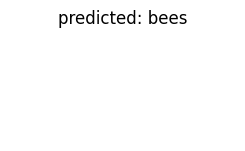

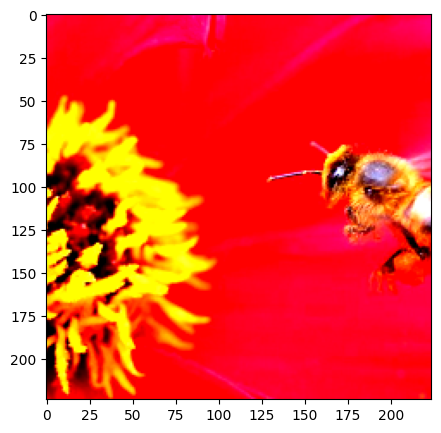

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


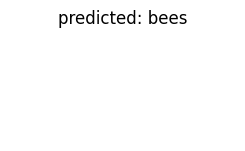

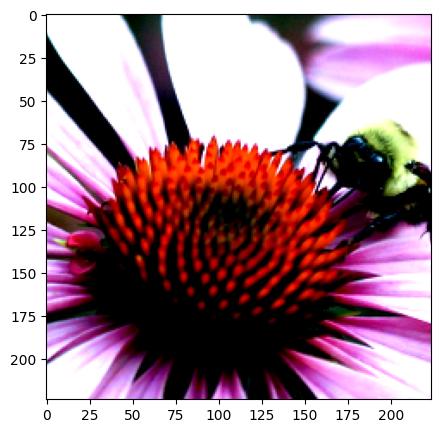

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


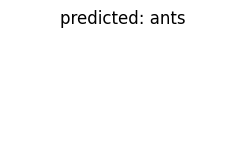

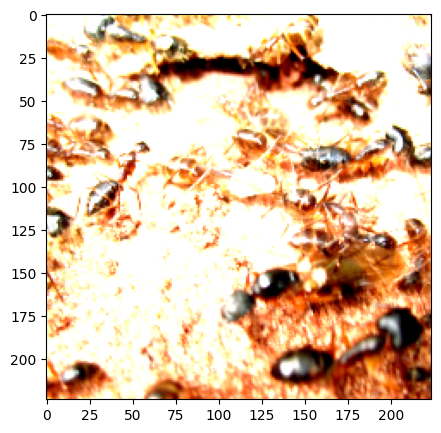

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


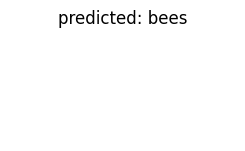

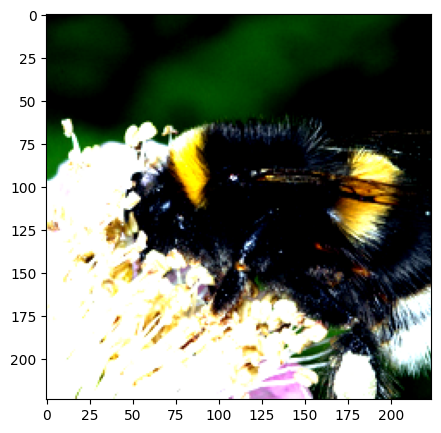

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


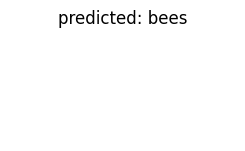

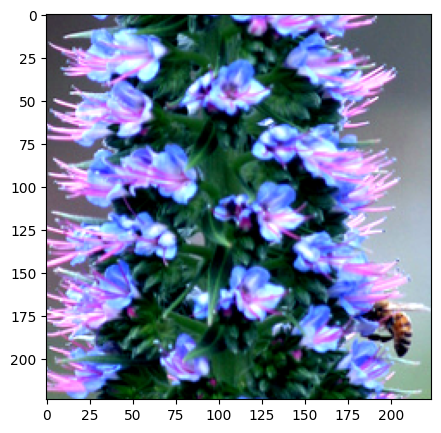

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


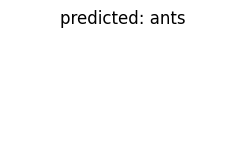

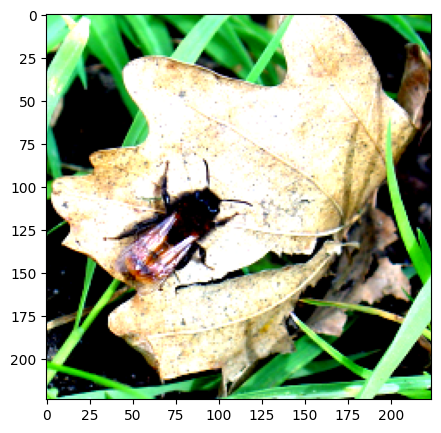

In [30]:
visualize_model(model_ft)

# 고정된 특징 추출기로써의 CNN
- 마지막 계층을 제외한 신경망의 모든 부분을 고정
- required_grad == False로 설정하여 매개변수를 고정함으로써 backward() 중에 경사도가 계산되지 않도록 한다.

In [32]:
model_conv = models.resnet18(weights=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.0001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [33]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epoches=20)

Epoch 0 / 19
--------------------
train Loss: 0.7412	 Accuracy: 0.4877
val Loss: 0.5442	 Accuracy: 0.7582

Epoch 1 / 19
--------------------
train Loss: 0.6070	 Accuracy: 0.6680
val Loss: 0.4375	 Accuracy: 0.8758

Epoch 2 / 19
--------------------
train Loss: 0.5079	 Accuracy: 0.7787
val Loss: 0.3750	 Accuracy: 0.9020

Epoch 3 / 19
--------------------
train Loss: 0.5346	 Accuracy: 0.7295
val Loss: 0.4529	 Accuracy: 0.7712

Epoch 4 / 19
--------------------
train Loss: 0.4986	 Accuracy: 0.7746
val Loss: 0.2923	 Accuracy: 0.9216

Epoch 5 / 19
--------------------
train Loss: 0.4373	 Accuracy: 0.8279
val Loss: 0.2740	 Accuracy: 0.9150

Epoch 6 / 19
--------------------
train Loss: 0.4484	 Accuracy: 0.8279
val Loss: 0.2578	 Accuracy: 0.9281

Epoch 7 / 19
--------------------
train Loss: 0.4185	 Accuracy: 0.8279
val Loss: 0.2540	 Accuracy: 0.9412

Epoch 8 / 19
--------------------
train Loss: 0.4377	 Accuracy: 0.8320
val Loss: 0.2430	 Accuracy: 0.9346

Epoch 9 / 19
--------------------
tra

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


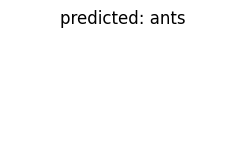

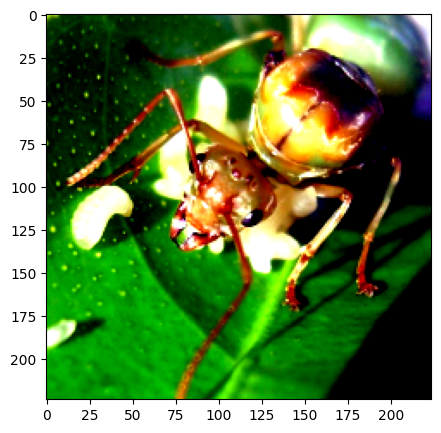

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


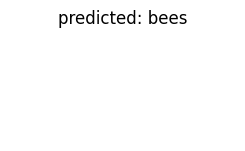

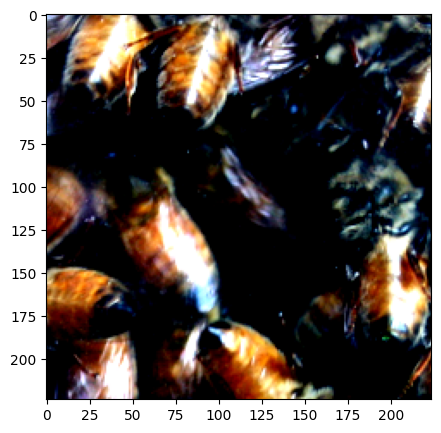

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


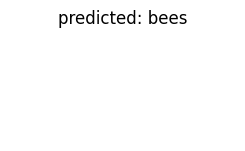

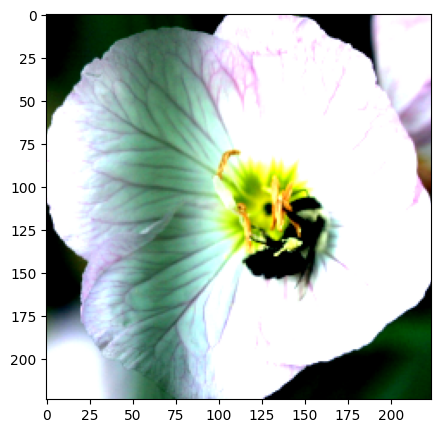

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


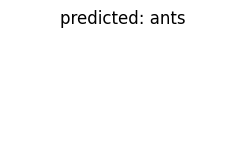

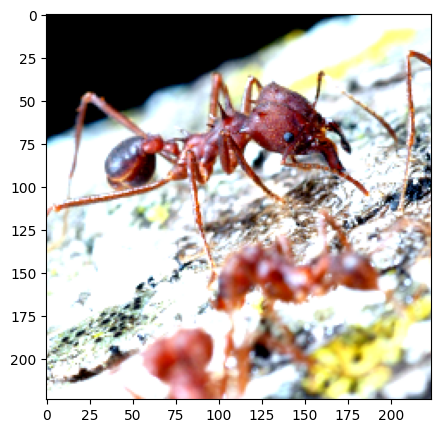

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


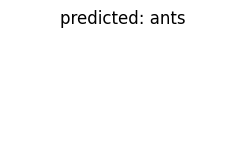

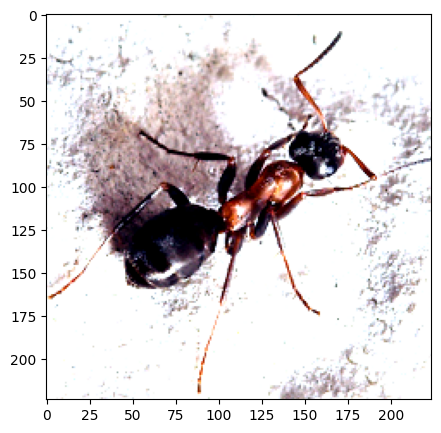

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


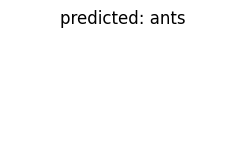

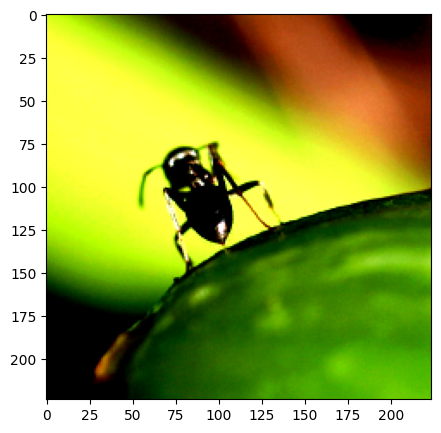

In [34]:
visualize_model(model_conv)